#Imports & Notes:

In [ ]:
# Name: Pavitra Patel

import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# All Tasks Setup:

In [ ]:
# This class contains complete setup/algorithm for both logic bot and model/network bot to play a game
class MineSweeper_Bots:
    def __init__(self, rows, cols, num_of_mines, allow_mines, allow_print):
        self.rows = rows
        self.cols = cols
        self.num_of_mines = num_of_mines
        self.allow_mines = allow_mines
        self.allow_print = allow_print
        self.adj_directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        self.reset()

    def reset(self):
        """
        Reset or initialize the board at the start of a new game. This method sets up the board, mines,
        and other game variables to their starting state.
        """
        self.board = [['#' for _ in range(self.cols)] for _ in range(self.rows)]
        self.cells_remaining = set((i, j) for i in range(self.rows) for j in range(self.cols))
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.clue_number = {}
        self.revealed_cells = set()
        self.mines_triggered = set()

        self.input_states = []
        self.output_states = []

        # Select the initial safe cell randomly and set it up without a mine
        r, c = random.randint(0, self.rows - 1), random.randint(0, self.cols - 1)
        self.initial_safe_cell(r, c)

    def initial_safe_cell(self, r, c):
        """
        Set up the initial safe cell and its neighbors. The selected cell and its neighbors are cleared
        of mines and marked safe.
        :param r: Row index of the initially selected safe cell.
        :param c: Column index of the initially selected safe cell.
        """
        self.board[r][c] = '0'  # Set the clue of the initial cell to 0, indicating no adjacent mines
        self.cells_remaining.remove((r, c))
        self.revealed_cells.add((r, c))
        self.clue_number[(r, c)] = 0

        valid_neighbors = self.get_neighbors((r, c))
        self.inferred_safe.update(valid_neighbors)
        for nei in valid_neighbors:
            self.cells_remaining.remove(nei)

        # Print the initial board setup if allowed
        if self.allow_print:
            self.print_board()

        # Exclude the initial safe cell and its neighbors from being potential mine locations
        possible_mine_locations = list(self.cells_remaining - self.inferred_safe)
        self.mines = set(random.sample(possible_mine_locations, self.num_of_mines))

    def get_neighbors(self, cell):
        """
        Get all valid neighboring cells of a given cell.
        :param cell: A tuple (r, c) representing the cell for which neighbors are to be found.
        :return: A set of tuples representing the valid neighbors of the given cell.
        """
        r, c = cell
        return {(r + dr, c + dc) for dr, dc in self.adj_directions if 0 <= r + dr < self.rows and 0 <= c + dc < self.cols}

    def print_board(self):
        """
        Print the current state of the minesweeper board.
        """
        for row in self.board:
            print(' '.join(str(cell) for cell in row))
        print()

    def reveal_clue(self, reveal_cell):
        valid_neighbors = self.get_neighbors(reveal_cell)
        return sum(1 for nei in valid_neighbors if nei in self.mines)

    # Logic Bot play
    def play(self):
        while True:
            if (self.rows*self.cols)-self.num_of_mines == len(self.revealed_cells):
                return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states

            if self.inferred_safe:
                reveal_cell = self.inferred_safe.pop()
            else:
                reveal_cell = self.cells_remaining.pop()

            if reveal_cell in self.mines:
                self.mines_triggered.add(reveal_cell)
                r_m, c_m = reveal_cell
                self.board[r_m][c_m] = 'M'
                if not self.allow_mines:
                    if self.allow_print:
                        self.print_board()
                    self.generate_data()
                    return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states
            else:
                self.revealed_cells.add(reveal_cell)
                reveal_cell_clue = self.reveal_clue(reveal_cell)
                self.clue_number[reveal_cell] = reveal_cell_clue
                r, c = reveal_cell
                self.board[r][c] = str(reveal_cell_clue)

            if self.allow_print:
                self.print_board()
            self.generate_data()

            for cell, clue in self.clue_number.items():
                valid_neighbors = self.get_neighbors(cell)
                num_nei_inferred_mines = sum(1 for nei in valid_neighbors if nei in self.inferred_mine)
                num_unrevealed_nei = sum(1 for nei in valid_neighbors if nei not in self.revealed_cells)

                if (clue - num_nei_inferred_mines) == num_unrevealed_nei:
                    for nei in valid_neighbors:
                        if nei not in self.revealed_cells:
                            self.inferred_mine.add(nei)
                            # self.cells_remaining.remove(nei)
                            self.cells_remaining.discard(nei)

                num_nei_revealed_or_inferred_safe = 0
                for nei in valid_neighbors:
                    if nei in self.revealed_cells or nei in self.inferred_safe:
                        num_nei_revealed_or_inferred_safe += 1

                if (len(valid_neighbors) - clue) - num_nei_revealed_or_inferred_safe == num_unrevealed_nei:
                    for nei in valid_neighbors:
                        if nei not in self.revealed_cells:
                            self.inferred_safe.add(nei)
                            self.cells_remaining.remove(nei)

    def generate_data(self):
        # Input: Convert self.board -> For clue #: 0 to 8, For Unclicked: 9, For Mine: 10
        # Output: Convert self.board -> For Mine: 0, For Safe: 1
        temp_i = copy.deepcopy(self.board)
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                if element == 'M':
                    num = 10
                elif element == '#':
                    num = 9
                else:
                    num = int(element)
                temp_i[i][j] = num
        self.input_states.append(temp_i)

        temp_o = copy.deepcopy(self.board)
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                temp_o[i][j] = 0 if (i, j) in self.mines else 1
        self.output_states.append(temp_o)

    # Model Bot play
    def model_play(self, model, embeddings):
        model.eval()
        for cell in self.inferred_safe:
            self.cells_remaining.add(cell)
        while self.inferred_safe:
            self.inferred_safe.pop()

        while True:
            if (self.rows * self.cols - self.num_of_mines) == len(self.revealed_cells):
                return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states

            c_s = [[9 if cell == '#' else (10 if cell == 'M' else int(cell)) for cell in row] for row in self.board]
            current_state = torch.tensor(c_s, dtype=torch.long)
            embedded_input = embeddings(current_state).unsqueeze(0)  # Add batch dimension
            board_tensor = embedded_input.permute(0, 3, 1, 2)  # Rearrange to [batch, channels, height, width]

            # Predict the safest cell to reveal next
            with torch.no_grad():
                predictions = model(board_tensor).squeeze(0)  # Remove batch dimension

            # Choose the cell with the highest safety score
            max_prob = 0
            cell_to_reveal = None
            for r in range(self.rows):
                for c in range(self.cols):
                    if (r, c) in self.cells_remaining and predictions[r][c] > max_prob:
                        max_prob = predictions[r][c]
                        cell_to_reveal = (r, c)
            if self.allow_print:
                print(f"Clicking: {cell_to_reveal}")

            if cell_to_reveal in self.mines:
                self.mines_triggered.add(cell_to_reveal)
                r, c = cell_to_reveal
                self.board[r][c] = 'M'
                if not self.allow_mines:
                    if self.allow_print:
                        self.print_board()
                    self.generate_data()
                    return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states
            else:
                r, c = cell_to_reveal
                self.revealed_cells.add(cell_to_reveal)
                clue = self.reveal_clue(cell_to_reveal)
                self.board[r][c] = str(clue)

            self.cells_remaining.remove(cell_to_reveal)

            if self.allow_print:
                self.print_board()
            self.generate_data()

In [ ]:
# This method is meant for easy reuse combining many functionalities
# rows -> rows in a board
# cols -> columns in a board
# num_of_mines -> number of mines on a board
# allow_mines -> when set to True, the game is allowed to continue after a mine is triggered until the last safe cell is explored
# allow_board_print -> prints the game played
# num_game_play -> number of games to play
# flag_logic_bot -> game is played by logic bot when set to true
# model, embeddings -> when flag_logic_bot is False and model, embeddings is passed, the game is played by model/network bot
# The method also returns detailed stats of games played

def run_bot_and_get_stats(rows, cols, num_of_mines, allow_mines, allow_board_print, num_game_play, flag_logic_bot, model, embeddings):
    won = 0
    cells_opened_list = []
    mines_triggered_list = []

    input_states = []
    output_states = []

    for i in range(num_game_play):
        print(i)
        bot = MineSweeper_Bots(rows, cols, num_of_mines, allow_mines, allow_board_print)
        if flag_logic_bot:
            num_cells_opened, num_mines_triggered, i_states, o_states = bot.play()
        else:
            num_cells_opened, num_mines_triggered, i_states, o_states = bot.model_play(model, embeddings)
        if num_cells_opened == ((rows * cols) - num_of_mines) and num_mines_triggered == 0:
            won += 1
        cells_opened_list.append(num_cells_opened)
        mines_triggered_list.append(num_mines_triggered)
        input_states.extend(i_states)
        output_states.extend(o_states)

    # Calculating averages
    avg_cells_opened = np.mean(cells_opened_list)
    avg_mines_triggered = np.mean(mines_triggered_list)

    # Calculating variances
    var_cells_opened = np.var(cells_opened_list)
    var_mines_triggered = np.var(mines_triggered_list)

    print(f"Count Bot Won: {won}")
    print(f"Avg. Cells Opened: {avg_cells_opened}, Variance: {var_cells_opened}")
    print(f"Avg. Mines Triggered: {avg_mines_triggered}, Variance: {var_mines_triggered}")
    print(f"Data Points Generated: {len(input_states)}")

    return input_states, output_states, won, avg_cells_opened, avg_mines_triggered, var_cells_opened, var_mines_triggered

#Task 1: Easy Level

In [ ]:
# This code approximately takes 4 mins to run on ilab2 cpu
# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_train1, output_states_train1, _, _, _, _, _ = run_bot_and_get_stats(9, 9, 10, False, False, 4000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_train2, output_states_train2, _, _, _, _, _ = run_bot_and_get_stats(9, 9, 10, True, False, 4000, True, None, None)

input_states_train = input_states_train1 + input_states_train2
output_states_train = output_states_train1 + output_states_train2

# Generate Test Dataset (Approx. 20%)
print("Generating Test Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_test1, output_states_test1, _, _, _, _, _ = run_bot_and_get_stats(9, 9, 10, False, False, 1000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_test2, output_states_test2, _, _, _, _, _ = run_bot_and_get_stats(9, 9, 10, True, False, 1000, True, None, None)

input_states_test = input_states_test1 + input_states_test2
output_states_test = output_states_test1 + output_states_test2

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 148
Avg. Cells Opened: 50.10425, Variance: 225.23338193750004
Avg. Mines Triggered: 0.963, Variance: 0.03563099999999999
Data Points Generated: 200269

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 134
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 3.0295, Variance: 2.1726297499999996
Data Points Generated: 292118
Generating Test Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 28
Avg. Cells Opened: 50.137, Variance: 230.00623099999996
Avg. Mines Triggered: 0.972, Variance: 0.027215999999999997
Data Points Generated: 50109

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 33
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 2.955, Variance: 2.196975
Data Points Generated: 72955


In [ ]:
embedding_dim = 3
num_of_embeddings = 11
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

class Minesweeper_Model_Easy(nn.Module):
    def __init__(self, embedding_dim):
        super(Minesweeper_Model_Easy, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(9 * 9 * 256, 9 * 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = x.reshape(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x.reshape(-1, 9, 9)

def get_output(embeddings, model, x):
    x = embeddings(x)
    x = x.permute(0, 3, 1, 2)
    return model(x)

In [ ]:
# Initialize model
model_easy = Minesweeper_Model_Easy(embedding_dim)
print(model_easy)
print()
# Calculate and print the total number of parameters
total_params = sum(p.numel() for p in model_easy.parameters())
print("Total number of parameters: ", total_params)

# Define optimizers
model_easy_optimizer = torch.optim.SGD(model_easy.parameters(), lr=0.01)

criterion = nn.BCELoss()

Minesweeper_Model_Easy(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20736, out_features=81, bias=True)
)

Total number of parameters:  2069073


In [ ]:
train_losses = []
test_losses = []

def train_and_test(model, embeddings, train_dataloader, test_dataloader, model_optimizer, criterion, epochs):
    for epoch in range(epochs):
        # Set model to training mode
        model.train()

        # Only the model parameters are trainable
        optimizer = model_optimizer

        # Training phase
        total_train_loss = 0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.long(), targets.float()  # Correct data types
            optimizer.zero_grad()
            outputs = get_output(embeddings, model, inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)  # Store train loss for plotting

        # Testing phase
        model.eval()  # Set model to evaluation mode
        total_test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.long(), targets.float()
                outputs = get_output(embeddings, model, inputs)
                loss = criterion(outputs, targets)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)  # Store test loss for plotting

        # Print average losses after each epoch
        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}')

In [ ]:
# This code approximately takes 45 mins to train on ilab2 cpu
train_and_test(model_easy, embeddings, train_dataloader, test_dataloader, model_easy_optimizer, criterion, 10)

Epoch 1: Train Loss = 0.2892, Test Loss = 0.2503
Epoch 2: Train Loss = 0.2263, Test Loss = 0.2250
Epoch 3: Train Loss = 0.2061, Test Loss = 0.2123
Epoch 4: Train Loss = 0.1938, Test Loss = 0.2041
Epoch 5: Train Loss = 0.1854, Test Loss = 0.1988
Epoch 6: Train Loss = 0.1793, Test Loss = 0.1951
Epoch 7: Train Loss = 0.1746, Test Loss = 0.1925
Epoch 8: Train Loss = 0.1708, Test Loss = 0.1908
Epoch 9: Train Loss = 0.1676, Test Loss = 0.1896
Epoch 10: Train Loss = 0.1649, Test Loss = 0.1888


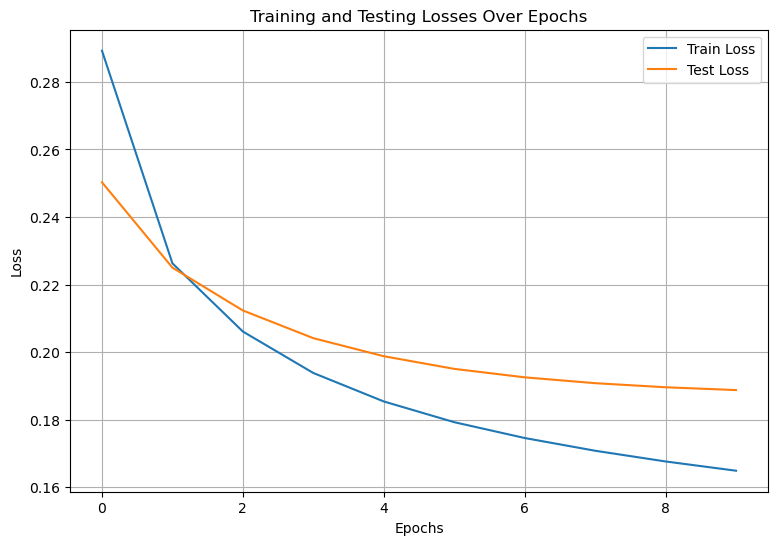

In [ ]:
# Plot training and testing losses
plt.figure(figsize=(9, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the model
torch.save(model_easy, 'model_easy_1.pth')

# Save the embeddings
embeddings_weights = embeddings.weight.data
torch.save(embeddings_weights, 'embeddings_easy_1.pth')

In [ ]:
# Load the model
model_easy = torch.load('model_easy_1.pth')
model_easy.eval()

# Load the embeddings
loaded_embeddings_tensor = torch.load('embeddings_easy_1.pth')
num_embeddings, embedding_dim = loaded_embeddings_tensor.size(0), loaded_embeddings_tensor.size(1)
embeddings = nn.Embedding(num_embeddings, embedding_dim)
embeddings.weight.data.copy_(loaded_embeddings_tensor)
embeddings.weight.requires_grad = False

In [ ]:
# This code approximately takes 2 mins to run on ilab2 cpu
# Logic Bot Performance on Easy Level - Game ends after a mine is triggered
_, _, won_e1, avg_cells_opened_e1, avg_mines_triggered_e1, var_cells_opened_e1, var_mines_triggered_e1 = run_bot_and_get_stats(9, 9, 10, False, False, 8000, True, None, None)

Count Bot Won: 255
Avg. Cells Opened: 49.960875, Variance: 227.842344234375
Avg. Mines Triggered: 0.968125, Variance: 0.030858984375
Data Points Generated: 399432


In [ ]:
# This code approximately takes 18 mins to run on ilab2 cpu
# Model Performance on Easy Level - Game ends after a mine is triggered
_, _, won_e2, avg_cells_opened_e2, avg_mines_triggered_e2, var_cells_opened_e2, var_mines_triggered_e2 = run_bot_and_get_stats(9, 9, 10, False, False, 8000, False, model_easy, embeddings)

Count Bot Won: 1696
Avg. Cells Opened: 61.26825, Variance: 198.52629193750002
Avg. Mines Triggered: 0.788, Variance: 0.16705600000000004
Data Points Generated: 488450


In [ ]:
# This code approximately takes 3 mins to run on ilab2 cpu
# Logic Bot Performance on Easy Level - Game ends only after all safe cells have been discovered, allowed to continue afte a mine is triggered
_, _, won_e3, avg_cells_opened_e3, avg_mines_triggered_e3, var_cells_opened_e3, var_mines_triggered_e3 = run_bot_and_get_stats(9, 9, 10, True, False, 8000, True, None, None)

Count Bot Won: 255
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 3.030625, Variance: 2.220437109375
Data Points Generated: 584245


In [ ]:
# This code approximately takes 30 mins to run on ilab2 cpu
# Model Performance on Easy Level - Game ends only after all safe cells have been discovered, allowed to continue afte a mine is triggered
_, _, won_e4, avg_cells_opened_e4, avg_mines_triggered_e4, var_cells_opened_e4, var_mines_triggered_e4 = run_bot_and_get_stats(9, 9, 10, True, False, 8000, False, model_easy, embeddings)

Count Bot Won: 1679
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 1.65025, Variance: 1.9026749375000003
Data Points Generated: 573202


#Task 1: Intermediate Level

In [ ]:
# This code approximately takes 18 mins to run on ilab2 gpu
# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_train1, output_states_train1, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 3000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_train2, output_states_train2, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 3000, True, None, None)
print()

input_states_train = input_states_train1 + input_states_train2
output_states_train = output_states_train1 + output_states_train2


# Generate Test Dataset (Approx. 20%)
print("Generating Test Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_test1, output_states_test1, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 750, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_test2, output_states_test2, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 750, True, None, None)

input_states_test = input_states_test1 + input_states_test2
output_states_test = output_states_test1 + output_states_test2

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 79.5702, Variance: 1671.0446719600002
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 397851

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.4608, Variance: 11.12846336
Data Points Generated: 1157304

Generating Test Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 80.48, Variance: 1717.0816
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 100600

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.4408, Variance: 11.516895360000001
Data Points Generated: 289301


In [ ]:
num_of_embeddings = 11
embedding_dim = 3
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

def get_output(embeddings, model, x):
    x = embeddings(x)
    x = x.permute(0, 3, 1, 2)
    return model(x)

class Minesweeper_Model_Medium(nn.Module):
    def __init__(self):
        super(Minesweeper_Model_Medium, self).__init__()
        self.conv1 = nn.Conv2d(embedding_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(128 * 16 * 16, 16 * 16)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout1(x)
        x = x.reshape(-1, 128 * 16 * 16)
        x = torch.sigmoid(self.fc1(x))
        return x.view(-1, 16, 16)

model_medium = Minesweeper_Model_Medium()
model_medium_optimizer = torch.optim.SGD(model_medium.parameters(), lr=0.01, weight_decay=1e-3)
criterion = nn.BCELoss()

print(model_medium)
print()
total_params = sum(p.numel() for p in model_medium.parameters())
print("Total number of parameters: ", total_params)

Minesweeper_Model_Medium(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
)

Total number of parameters:  8482560


In [ ]:
# This code approximately takes 98 mins to run on ilab2 gpu
train_losses = []
test_losses = []
train_and_test(model_medium, embeddings, train_dataloader, test_dataloader, model_medium_optimizer, criterion, 10)

Epoch 1: Train Loss = 0.3829, Test Loss = 0.3521
Epoch 2: Train Loss = 0.3041, Test Loss = 0.3140
Epoch 3: Train Loss = 0.2698, Test Loss = 0.2933
Epoch 4: Train Loss = 0.2504, Test Loss = 0.2813
Epoch 5: Train Loss = 0.2382, Test Loss = 0.2735
Epoch 6: Train Loss = 0.2299, Test Loss = 0.2691
Epoch 7: Train Loss = 0.2240, Test Loss = 0.2653
Epoch 8: Train Loss = 0.2196, Test Loss = 0.2631
Epoch 9: Train Loss = 0.2160, Test Loss = 0.2610
Epoch 10: Train Loss = 0.2131, Test Loss = 0.2597


In [ ]:
# Save the model
torch.save(model_medium, 'model_medium_1.pth')

# Save the embeddings
embeddings_weights = embeddings.weight.data
torch.save(embeddings_weights, 'embeddings_med_1.pth')

In [ ]:
# Load the model
model_medium = torch.load('model_medium_1.pth')
model_medium.eval()

# Load the embeddings
loaded_embeddings_tensor = torch.load('embeddings_med_1.pth')
num_embeddings, embedding_dim = loaded_embeddings_tensor.size(0), loaded_embeddings_tensor.size(1)
embeddings = nn.Embedding(num_embeddings, embedding_dim)
embeddings.weight.data.copy_(loaded_embeddings_tensor)
embeddings.weight.requires_grad = False

In [ ]:
# This code approximately takes 38 mins to run on ilab2 gpu
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 1000, False, model_medium, embeddings)
print()
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 1000, False, model_medium, embeddings)

Count Bot Won: 0
Avg. Cells Opened: 80.538, Variance: 1620.846556
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 80538

Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 14.475, Variance: 25.475375
Data Points Generated: 229475


In [ ]:
# This code approximately takes 18 mins to run on ilab2 gpu
# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_train1, output_states_train1, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 3000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_train2, output_states_train2, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 3000, True, None, None)
print()

input_states_train = input_states_train1 + input_states_train2
output_states_train = output_states_train1 + output_states_train2

# Generate Test Dataset (Approx. 20%)
print("Generating Test Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_test1, output_states_test1, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 750, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_test2, output_states_test2, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 750, True, None, None)

input_states_test = input_states_test1 + input_states_test2
output_states_test = output_states_test1 + output_states_test2

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 78.97133333333333, Variance: 1683.9491782222221
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 236914

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.527, Variance: 11.459937666666665
Data Points Generated: 694581

Generating Test Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 80.03733333333334, Variance: 1683.6359395555555
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 60028

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.417333333333332, Variance: 11.512499555555555
Data Points Generated: 173563


In [ ]:
# This code approximatley takes 18 mins to run on ilab2 gpu
train_and_test(model_medium, embeddings, train_dataloader, test_dataloader, model_medium_optimizer, criterion, 2)

Epoch 1: Train Loss = 0.2618, Test Loss = 0.2605
Epoch 2: Train Loss = 0.2618, Test Loss = 0.2603


In [ ]:
# Save the model
torch.save(model_medium, 'model_medium_2.pth')

In [ ]:
# Load the model
model_medium = torch.load('model_medium_2.pth')
model_medium.eval()

In [ ]:
# This code approximately takes 38 mins to run on ilab2 gpu
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 1000, False, model_medium, embeddings)
print()
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 1000, False, model_medium, embeddings)

Count Bot Won: 0
Avg. Cells Opened: 83.784, Variance: 1676.8573439999998
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 82075

Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 14.361, Variance: 22.450679
Data Points Generated: 229361
The task took 2041.4086673259735 seconds.



#Task 1: Expert

In [ ]:
# This code approximately takes 52 mins to run on ilab2 gpu
# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_train1, output_states_train1, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, False, False, 5000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_train2, output_states_train2, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, True, False, 3000, True, None, None)
print()

input_states_train = input_states_train1 + input_states_train2
output_states_train = output_states_train1 + output_states_train2


# Generate Test Dataset (Approx. 20%)
print("Generating Test Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_test1, output_states_test1, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, False, False, 1250, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_test2, output_states_test2, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, True, False, 750, True, None, None)

input_states_test = input_states_test1 + input_states_test2
output_states_test = output_states_test1 + output_states_test2

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 54.2302, Variance: 1294.6592079600002
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 271151

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 381.0, Variance: 0.0
Avg. Mines Triggered: 54.367, Variance: 31.980977666666668
Data Points Generated: 1303101

Generating Test Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 55.6104, Variance: 1320.36101184
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 69513

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 381.0, Variance: 0.0
Avg. Mines Triggered: 54.29333333333334, Variance: 33.10062222222222
Data Points Generated: 325720


In [ ]:
num_of_embeddings = 11
embedding_dim = 3
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

def get_output(embeddings, model, x):
    x = embeddings(x)
    x = x.permute(0, 3, 1, 2)
    return model(x)

class Minesweeper_Model_expert(nn.Module):
    def __init__(self):
        super(Minesweeper_Model_expert, self).__init__()
        self.conv1 = nn.Conv2d(embedding_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 30 * 16, 30 * 16)
        self.dropout1 = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout1(x)
        x = x.reshape(-1, 256 * 30 * 16)
        x = torch.sigmoid(self.fc1(x))
        return x.view(-1, 30, 16)

model_expert = Minesweeper_Model_expert()
model_expert_optimizer = torch.optim.SGD(model_expert.parameters(), lr=0.01, weight_decay=1e-3)
criterion = nn.BCELoss()
print(model_expert)
print()
total_params = sum(p.numel() for p in model_expert.parameters())
print("Total number of parameters: ", total_params)

Minesweeper_Model_expert(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=122880, out_features=480, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
)

Total number of parameters:  59372256


In [ ]:
# This code approximately takes 1387 mins to run on ilab2 gpu
train_losses = []
test_losses = []
train_and_test(model_expert, embeddings, train_dataloader, test_dataloader, model_expert_optimizer, criterion, 10)

Epoch 1: Train Loss = 0.3998, Test Loss = 0.4209
Epoch 2: Train Loss = 0.3002, Test Loss = 0.3920
Epoch 3: Train Loss = 0.2592, Test Loss = 0.3725
Epoch 4: Train Loss = 0.2376, Test Loss = 0.3612
Epoch 5: Train Loss = 0.2246, Test Loss = 0.3539
Epoch 6: Train Loss = 0.2158, Test Loss = 0.3487
Epoch 7: Train Loss = 0.2092, Test Loss = 0.3445
Epoch 8: Train Loss = 0.2041, Test Loss = 0.3408
Epoch 9: Train Loss = 0.1998, Test Loss = 0.3377
Epoch 10: Train Loss = 0.1962, Test Loss = 0.3353


In [ ]:
# Save the model
torch.save(model_expert, 'model_expert_1.pth')

# Save the embeddings
embeddings_weights = embeddings.weight.data
torch.save(embeddings_weights, 'embeddings_exp_1.pth')

In [ ]:
# Load the model
model_expert = torch.load('model_expert_1.pth')
model_expert.eval()

# Load the embeddings
loaded_embeddings_tensor = torch.load('embeddings_exp_1.pth')
num_embeddings, embedding_dim = loaded_embeddings_tensor.size(0), loaded_embeddings_tensor.size(1)
embeddings = nn.Embedding(num_embeddings, embedding_dim)
embeddings.weight.data.copy_(loaded_embeddings_tensor)
embeddings.weight.requires_grad = False

In [ ]:
# This code approximately takes 76 mins to run on ilab2 gpu
_, _, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, False, False, 500, False, model_expert, embeddings)
print()
_, _, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, True, False, 500, False, model_expert, embeddings)

Count Bot Won: 0
Avg. Cells Opened: 54.04, Variance: 806.5443999999999
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 26970

Count Bot Won: 0
Avg. Cells Opened: 381.0, Variance: 0.0
Avg. Mines Triggered: 61.43, Variance: 134.4771
Data Points Generated: 221215


#Task 1 Plots & Write up:

**Note:**
1. The following questions are answered below:
- **Q. How are you representing your input?**
- **Q. What output are you going to be calculating, and how is it used to pick a cell to open?**
- **Q. What model structure are you using?**
- **Q. Be clear in your writeup about anything you do to make training easier or more tractable, and what you do to avoid or handle the problem of overfitting.**
- **Q. How can you generate data for this task, what data should you generate, and how can you use it?**
2. All the factors between Easy, Intermediate, and Expert Level remain constant except for the fact that the models for each levels are different. In other words, in all three levels, the input space logic, output space logic, training and testing loops, optimizer, and the way the model makes decisions are same and only the model structures are different.

**Approach to Task 1:** Classify each cell in a representation of a board as safe or not safe/mine. Output a probability of being safe for each cell, and the model picks a cell with maximum probability.

**Input Space & Data Generation:** Input data to the model is a row*column board to the model. A 3-D fixed random embedding is applied to the input board. For each level of difficulty, the input to the model is current state of the minesweeper board embedded in 3-D. When generating data, each cell in the board has values from 0 to 10. 0 to 8 representing the clue numbers, 9 representing unclicked cells, and 10 representing a mine.

**Output Space (Y/True Label) & Data Generation:** The output dimension is a row*column board from the model. In each level of difficulty, the output board is passed through the Sigmoid activation function. This implies that at a time step in a game, the model outputs a probability between 0 and 1 for each cell. The model then picks a cell with maximum probability to make a potential safe move. When generating data, each cell in the board has a value of 0 or 1. 0 representing a mine cell and 1 representing a safe cell.

**Loss Function:** The loss function is Binary Cross Entropy.

**Optimizer:**

For Easy Level, SGD optimizer with a learning rate of 0.01.

For Intermediate and Expert Level, SGD optimizer, learning rate of 0.01, and a weight decay of 1e-3.

**Data Collection Strategy:** The logic bot is set to play and record data. For example, the logic bot plays a minesweeper game and survives a total of 25 steps. Then our dataset will be of length 25. We will have 25 input representations and 25 output representations as mentioned in Data Generation for Input and Output space above.

The dataset has two types of data:
1. When the logic bot is set to terminate after it triggers a mine. Here, not all safe cells are always explored.
2. When the logic bot is set to terminate after all safe cells are explored. Here, the logic bot can step on multiple mines and the game can still continue if there are safe cells remaining.

With the results achieved, we can conclude that the model learns better with this strategy. For each level, the dataset size is different. The ratio of 80% of data for training and 20% of data for testing stays roughly the constant.

For Easy Level, the logic bot was set to play for total of 10,000 games out of which data was generated (Total dataset of 615,451). Here, the board size is 9*9 and the number of mines on the board are 10.

For Intermediate Level, the logic bot was set to play for total of 7,500 games out of which data was generated (Total dataset 1,945,056). **Once the model was trained and tested for 10 epochs, an additional data of 7,500 games from logic bot was generated (Total dataset of 1,165,086) and the model was further trained and tested for 2 epochs.** Here, the board size is 16*16 and the number of mines on the board are 40.

For Expert Level, the logic bot was set to play for total of 10,000 games out of which data was generated (Total dataset of 1,969,485). Here, the board size is 30*16 and the number of mines on the board are 99.

**Model Structures:**

For Easy Level, the model consists of 4 CNN's followed by a Linear output layer. The first CNN layer can be considered as an input layer which takes in 3 input channels (3-D embedded board). The 4th CNN layer outputs 256 channels which is then passed to the linear output layer which reduces the dimensions to row*column board size. BatchNorm and ReLU activation function is applied after each CNN layer. In the forward function, Sigmoid activation function is applied to the board before outputting. The detailed model structure and the number of parameters of the model are printed above as output with model code.

For Intermediate Level, the model consists of 3 CNN's followed by a Linear output layer. The first CNN takes 3 input channels and the third CNN outputs 128 channels which is then passed through the linear output layer where the dimesnsions are reduced to row*column board size. BatchNorm and ReLU activation function is applied after each CNN layer. The dropout of 0.3 is applied after the third CNN layer. In the forward function, Sigmoid activation function is applied to the board before outputting. The detailed model structure and the number of parameters of the model are printed above as output with model code.

For Expert Level, the model consists of 4 CNN's followed by a Linear output layer. The first CNN layer can be considered as an input layer which takes in 3 input channels (3-D embedded board). The 4th CNN layer outputs 256 channels which is then passed to the linear output layer which reduces the dimensions to row*column board size. BatchNorm and ReLU activation function is applied after each CNN layer. The dropout of 0.3 is applied after the fourth CNN layer. In the forward function, Sigmoid activation function is applied to the board before outputting. The detailed model structure and the number of parameters of the model are printed above as output with model code.

**Q. How can you access the quality of your model?**

Ans: Listed below are the ways the quality of the model can be accessed and the ways listed have been used to access the quality of the model here:
1. Accuracy Statistics such as percentage of games won, the number of mines correctly identified, the number of safe cells correctly predicted or average number of steps in survival, etc ... We can also determine accuracy with the use of variance in each of these measures to understand the distribution.
2. When the testing loss improves over epochs the model demonstrates learning. If the number of parameters, dataset, and optimizer is not the best then the model never learns/generalizes (either the testing loss decreases very very slowly, or the testing loss starts to increase indicating overfitting in which case some form of regularization must be used).

**Q. Theoretically you could learn to mimic the logic bot (how?), but how could your network bot learn to be better?**

Ans: The answer to the question lies in the quality of the data that the network/model bot is trained on. If the dataset only contains data of the way the logic bot plays the game in which the game is terminated after stepping on a mine. The model would never see what the rest of the board looks like and would lack the ability to generalize at that point. Here, the model bot will in fact largely mimic the logic bot or do a bit better but not to a large extent. In order for the network bot to play well, the model needs to learn the rest of the unrevealed board too. In order to do that, we can allow the logic bot to continue the game even if it stepped on mines until the last safe cell is explored. This would allow the model bot to generalize even further and would perform better.

Another metric is that if the model is too simple and is trained on excessive data (more data then needed), then it would have largely learnt all situations that the logic bot has passed through. When evaluating, if the same senario occurs again then the model bot would mimic the logic bot (according to what it learnt, the data point exists at the time of training) instead of genralizing or doing better at that point. In order for network bot to perform better, the right amount of data is necessary. This can be achieved by starting with a small dataset and increasing it's size until we see better results.

**Q. How often the logic bot clear the board vs how often your neural network bot does.**

Ans: In order to understand how often the logic bot and the model bot clears the board for three difficulty levels we will access their win percentages and plot them below. The data below is obtained from the results above, manually extracted for ease (Once I got above results, I saved them. I didn't run again to store results in a list to avoid computational overhead again.)

**Easy Level Evaluation Metrics:**

The logic bot won 255 games out of 8000 games played.

The model bot won 1696 games out of 8000 games played.

**Intermediate Level Evaluation Metrics:**

The logic bot won 0 games out of 3000 games played.

The model bot won 0 games out of 1000 games played.

**Expert Level Evaluation Metrics:**

The logic bot won 0 games out of 5000 games played.

The model bot won 0 games out of 500 games played.

**Note:** The amount of games tested decreases over increase in difficulty level because the amount of time taken to play a game increased.

Given these results, we calcaute percentage of games won by each bot for each difficulty level and plot them below. We can conclude that the Easy Level model bot outperformed the Easy Level logic bot. The win percentage for Easy Level logic bot is 3.19% and the win percentage for Easy Level model bot is 21.20%. For Intermediate and Expert Level for each bot, the results remain the same (no games won).

The model for Easy Level saw in training data, what it looked like to win a game. In other words, the logic bot won few games, and the model learnt that data. As a result, during evaluation the model bot took better decisons to win more games as it generalized better. In training data for Intermediate and Expert Level, the logic bot won no games. As a result, during evaluation we see that the model bot never wins as well. This implies the significance of good data.

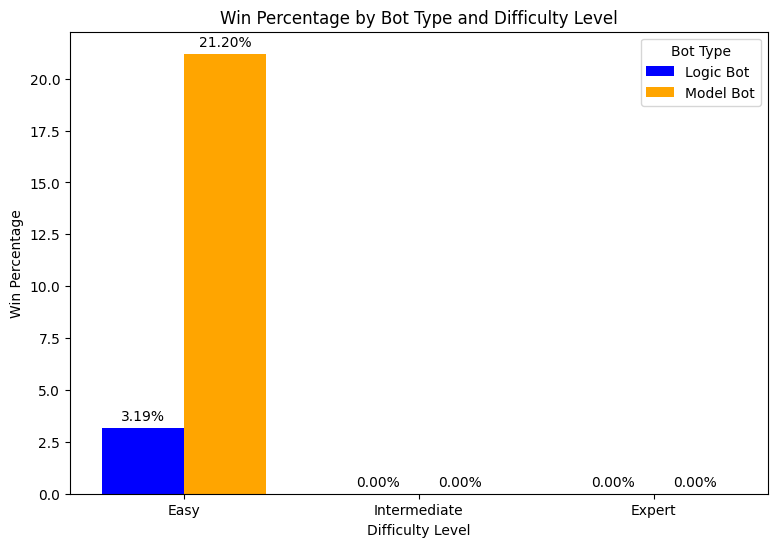

In [ ]:
# Create a DataFrame
data = {
    'Level': ['Easy', 'Easy', 'Intermediate', 'Intermediate', 'Expert', 'Expert'],
    'Bot Type': ['Logic', 'Model', 'Logic', 'Model', 'Logic', 'Model'],
    'Wins': [255, 1696, 0, 0, 0, 0],
    'Games': [8000, 8000, 3000, 1000, 500, 500]
}
df = pd.DataFrame(data)
# Define the correct order for difficulty levels
level_order = ['Easy', 'Intermediate', 'Expert']
df['Level'] = pd.Categorical(df['Level'], categories=level_order, ordered=True)
# Calculate win percentages
df['Win Percentage'] = (df['Wins'] / df['Games']) * 100
# Sort DataFrame by the 'Level' column to ensure correct plotting order
df.sort_values('Level', inplace=True)
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['blue', 'orange']  # Colors for Logic and Model bots
grouped = df.groupby('Level')
# Plotting each group
for i, (level, group) in enumerate(grouped):
    for j, (idx, row) in enumerate(group.iterrows()):
        ax.bar(i + j * 0.35, row['Win Percentage'], width=0.35, color=colors[j], label=f'{row["Bot Type"]} Bot' if i == 0 else "")
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Win Percentage')
ax.set_title('Win Percentage by Bot Type and Difficulty Level')
ax.set_xticks([i + 0.175 for i in range(len(grouped))])
ax.set_xticklabels([name for name, _ in grouped])
ax.legend(title="Bot Type")
# Adding percentages on top of the bars
def add_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_labels(ax)
plt.show()

**Q. The number of steps each bot survives, on average.**

Ans: Here, for each bot and difficulty level a game is terminated when stepped on a mine. The data below is obtained from the results above, manually extracted for ease (Once I got above results, I saved them. I didn't run again to store results in a list to avoid computational overhead again.) The plot is attached below.

**Easy Level Evaluation Metrics:**

The logic bot average survival is 49.96 steps based on 8000 games played.

The model bot average survival is 61.26 steps based on 8000 games played.

**Intermediate Level Evaluation Metrics:**

The logic bot average survival is 79.57 steps based on 3000 games played.

The model bot average survival is 83.78 steps based on 1000 games played.

**Expert Level Evaluation Metrics:**

The logic bot average survival is 54.23 steps based on 5000 games played.

The model bot average survival is 54.04 steps based on 500 games played.

**Note:** The amount of games tested decreases over increase in difficulty level because the amount of time taken to play a game increased.

Given these results, we can conclude that the model bot performed well in Easy and Intermediate Level compared to the logic bot. For Expert Level, we observe that the results for both bot remains the same (the model bot learns to mimic the logic bot).

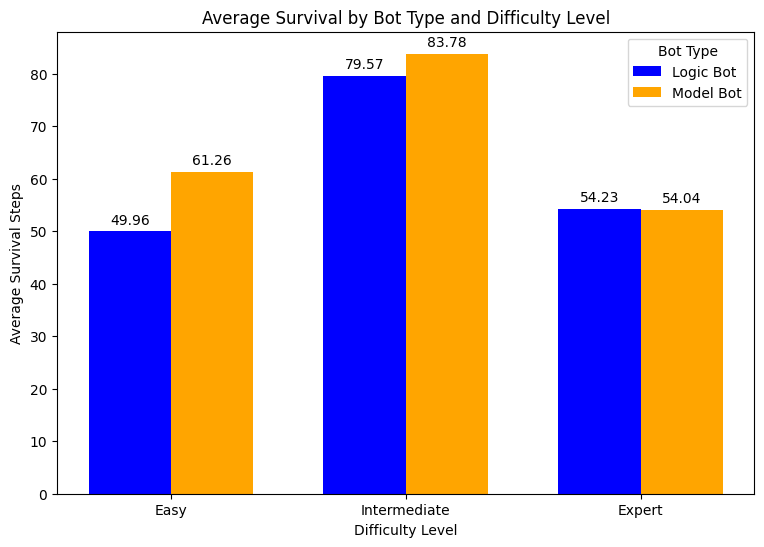

In [ ]:
# Creating the DataFrame
survival_data = {
    'Level': ['Easy', 'Easy', 'Intermediate', 'Intermediate', 'Expert', 'Expert'],
    'Bot Type': ['Logic', 'Model', 'Logic', 'Model', 'Logic', 'Model'],
    'Average Survival': [49.96, 61.26, 79.57, 83.78, 54.23, 54.04]
}
df_survival = pd.DataFrame(survival_data)
# Define the correct order for difficulty levels
level_order = ['Easy', 'Intermediate', 'Expert']
df_survival['Level'] = pd.Categorical(df_survival['Level'], categories=level_order, ordered=True)
# Sort DataFrame by the 'Level' column to ensure correct plotting order
df_survival.sort_values('Level', inplace=True)
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['blue', 'orange']  # Colors for Logic and Model bots
grouped = df_survival.groupby('Level')
# Plotting each group
for i, (level, group) in enumerate(grouped):
    for j, (idx, row) in enumerate(group.iterrows()):
        ax.bar(i + j * 0.35, row['Average Survival'], width=0.35, color=colors[j], label=f'{row["Bot Type"]} Bot' if i == 0 else "")
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Average Survival Steps')
ax.set_title('Average Survival by Bot Type and Difficulty Level')
ax.set_xticks([i + 0.175 for i in range(len(grouped))])
ax.set_xticklabels([name for name, _ in grouped])
ax.legend(title="Bot Type")
# Adding values on top of the bars
def add_values(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_values(ax)
plt.show()

**Q. The number of steps each bot survives, on average.**

Ans: The plot for average survival for each difficulty level with logic bot and model bot is attached just above this cell. Below, we access the survival using the variance. The data below is obtained from the results above, manually extracted for ease (Once I got above results, I saved them. I didn't run again to store results in a list to avoid computational overhead again.) The plot is attached below.

**Easy Level Evaluation Metrics:**

The logic bot average survival variance is 227.84 based on 8000 games played.

The model bot average survival variance is 198.52 based on 8000 games played.

**Intermediate Level Evaluation Metrics:**

The logic bot average survival variance is 1671.04 based on 3000 games played.

The model bot average survival variance is 1676.85 based on 1000 games played.

**Expert Level Evaluation Metrics:**

The logic bot average survival variance is 1294.65 based on 5000 games played.

The model bot average survival variance is 806.54 based on 500 games played.

**Note:** The amount of games tested decreases over increase in difficulty level because the amount of time taken to play a game increased.

Given these results, we can access how accurate our results are. In other words, we can access the distribution over the experiments performed. In this case, a low average survival variance for model bot determines it's ability to perform well. In Easy and Expert Level, the average survival variance for model bot is lower than the logic bot. We can further conclude, the model bot is performing well. For intermediate level, the average survival variance of logic bot and model bot is approximately the same (Hence, performing similarly).

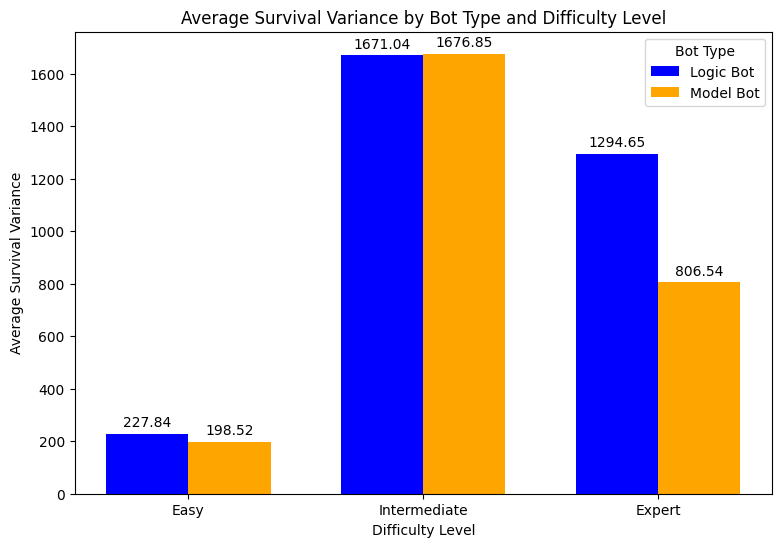

In [ ]:
# Creating the DataFrame
variance_data = {
    'Level': ['Easy', 'Easy', 'Intermediate', 'Intermediate', 'Expert', 'Expert'],
    'Bot Type': ['Logic', 'Model', 'Logic', 'Model', 'Logic', 'Model'],
    'Average Survival Variance': [227.84, 198.52, 1671.04, 1676.85, 1294.65, 806.54]
}
df_variance = pd.DataFrame(variance_data)
# Define the correct order for difficulty levels
level_order = ['Easy', 'Intermediate', 'Expert']
df_variance['Level'] = pd.Categorical(df_variance['Level'], categories=level_order, ordered=True)
# Sort DataFrame by the 'Level' column to ensure correct plotting order
df_variance.sort_values('Level', inplace=True)
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['blue', 'orange']  # Colors for Logic and Model bots
grouped = df_variance.groupby('Level')
# Plotting each group
for i, (level, group) in enumerate(grouped):
    for j, (idx, row) in enumerate(group.iterrows()):
        ax.bar(i + j * 0.35, row['Average Survival Variance'], width=0.35, color=colors[j], label=f'{row["Bot Type"]} Bot' if i == 0 else "")
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Average Survival Variance')
ax.set_title('Average Survival Variance by Bot Type and Difficulty Level')
ax.set_xticks([i + 0.175 for i in range(len(grouped))])
ax.set_xticklabels([name for name, _ in grouped])
ax.legend(title="Bot Type")
# Adding values on top of the bars
def add_values(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_values(ax)
plt.show()

**Q. If the bots are allowed to trigger mines, and keep going with that information, the average number of mines set off by the time the last safe cell is opened.**

Ans: The data below is obtained from the results above, manually extracted for ease (Once I got above results, I saved them. I didn't run again to store results in a list to avoid computational overhead again.) The plot is attached below.

**Easy Level Evaluation Metrics:**

The logic bot average mines stepped is 3.03 based on 8000 games played.

The model bot average mines stepped is 1.65 based on 8000 games played.

**Intermediate Level Evaluation Metrics:**

The logic bot average mines stepped is 16.46 based on 3000 games played.

The model bot average mines stepped is 14.36 based on 1000 games played.

**Expert Level Evaluation Metrics:**

The logic bot average mines stepped is 54.36 based on 5000 games played.

The model bot average mines stepped is 61.43 based on 500 games played.

**Note:** The amount of games tested decreases over increase in difficulty level because the amount of time taken to play a game increased.

Given these results, we can conclude that the model bot performed well in Easy and Intermediate Level compared to the logic bot. For Expert Level, we observe that the results are slightly bad for model bot compared to the logic bot. Here, the expert level model bot is only evaluated for 500 games. Evaluating for more games might give concrete and better results. Since, the expert level model took hours to train, didn't try experimenting further because the results are good enough to prove that with little more tuning (little more data and training for few more epochs) the model bot can do better here as well.

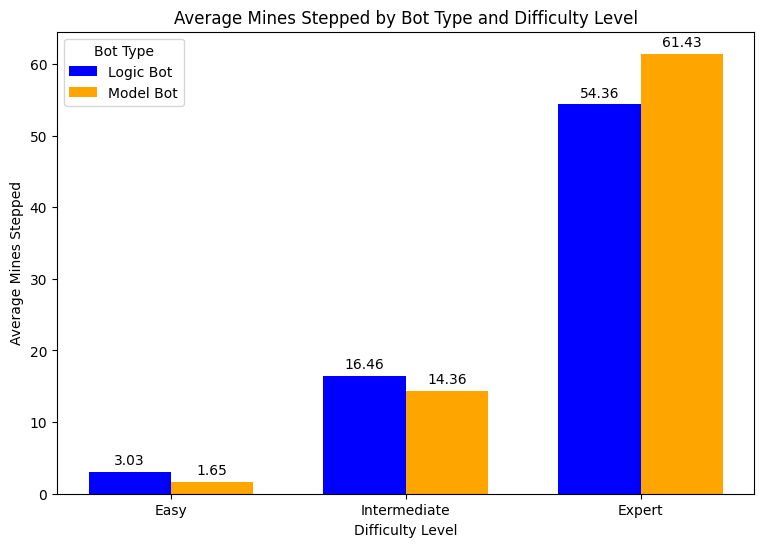

In [ ]:
# Creating the DataFrame
mines_data = {
    'Level': ['Easy', 'Easy', 'Intermediate', 'Intermediate', 'Expert', 'Expert'],
    'Bot Type': ['Logic', 'Model', 'Logic', 'Model', 'Logic', 'Model'],
    'Average Mines Stepped': [3.03, 1.65, 16.46, 14.36, 54.36, 61.43]
}
df_mines = pd.DataFrame(mines_data)
# Define the correct order for difficulty levels
level_order = ['Easy', 'Intermediate', 'Expert']
df_mines['Level'] = pd.Categorical(df_mines['Level'], categories=level_order, ordered=True)
# Sort DataFrame by the 'Level' column to ensure correct plotting order
df_mines.sort_values('Level', inplace=True)
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['blue', 'orange']  # Colors for Logic and Model bots
grouped = df_mines.groupby('Level')
# Plotting each group
for i, (level, group) in enumerate(grouped):
    for j, (idx, row) in enumerate(group.iterrows()):
        ax.bar(i + j * 0.35, row['Average Mines Stepped'], width=0.35, color=colors[j], label=f'{row["Bot Type"]} Bot' if i == 0 else "")
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Average Mines Stepped')
ax.set_title('Average Mines Stepped by Bot Type and Difficulty Level')
ax.set_xticks([i + 0.175 for i in range(len(grouped))])
ax.set_xticklabels([name for name, _ in grouped])
ax.legend(title="Bot Type")
# Adding values on top of the bars
def add_values(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_values(ax)
plt.show()

**Q. If the bots are allowed to trigger mines, and keep going with that information, the average number of mines set off by the time the last safe cell is opened.**

Ans: The plot for average mines stepped for each difficulty level with logic bot and model bot is attached just above this cell. Below, we access the average mines stepped using the variance. The data below is obtained from the results above, manually extracted for ease (Once I got above results, I saved them. I didn't run again to store results in a list to avoid computational overhead again.) The plot is attached below.

**Easy Level Evaluation Metrics:**

The logic bot average mines stepped variance is 2.22 based on 8000 games played.

The model bot average mines stepped variance is 1.90 based on 8000 games played.

**Intermediate Level Evaluation Metrics:**

The logic bot average mines stepped variance is 11.12 based on 3000 games played.

The model bot average mines stepped variance is 22.45 based on 1000 games played.

**Expert Level Evaluation Metrics:**

The logic bot average mines stepped variance is 31.98 based on 5000 games played.

The model bot average mines stepped variance is 134.47 based on 500 games played.

**Note:** The amount of games tested decreases over increase in difficulty level because the amount of time taken to play a game increased.

Given these results, we can access how accurate our results are. In other words, we can access the distribution over the experiments performed. In this case, a low average mines stepped variance for model bot determines it's ability to perform well. In Easy Level, the average mines stepped variance for model bot is lower than the logic bot. We can further conclude, the model bot is performing well.

However, for intermediate and expert level, the average mines stepped variance of model bot is much higher then the logic bot. Even though, the results for average mines stepped above are better for the model bot, the high variance suggests inaccuracy or instability of the model bot's performance. Here, the expert level model bot is only evaluated for 500 games and the intermediate level model bot is only evaluated for 1000 games. Evaluating for more games might give concrete and better results. Since, the expert level and intermediate level model took hours to train, didn't try experimenting further because the results are good enough to prove that with little more tuning (little more data and training for few more epochs) the model bot can do better here as well.

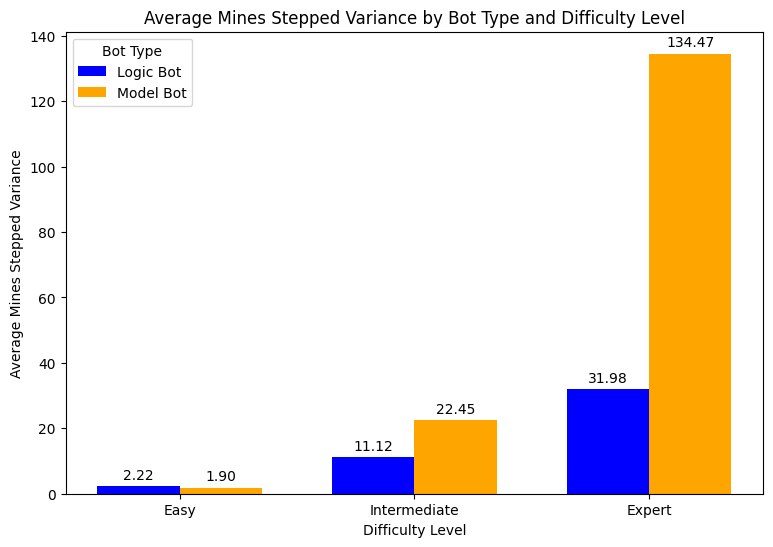

In [ ]:
# Creating the DataFrame
mines_variance_data = {
    'Level': ['Easy', 'Easy', 'Intermediate', 'Intermediate', 'Expert', 'Expert'],
    'Bot Type': ['Logic', 'Model', 'Logic', 'Model', 'Logic', 'Model'],
    'Average Mines Stepped Variance': [2.22, 1.90, 11.12, 22.45, 31.98, 134.47]
}
df_mines_variance = pd.DataFrame(mines_variance_data)
# Define the correct order for difficulty levels
level_order = ['Easy', 'Intermediate', 'Expert']
df_mines_variance['Level'] = pd.Categorical(df_mines_variance['Level'], categories=level_order, ordered=True)
# Sort DataFrame by the 'Level' column to ensure correct plotting order
df_mines_variance.sort_values('Level', inplace=True)
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['blue', 'orange']  # Colors for Logic and Model bots
grouped = df_mines_variance.groupby('Level')
# Plotting each group
for i, (level, group) in enumerate(grouped):
    for j, (idx, row) in enumerate(group.iterrows()):
        ax.bar(i + j * 0.35, row['Average Mines Stepped Variance'], width=0.35, color=colors[j], label=f'{row["Bot Type"]} Bot' if i == 0 else "")
ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Average Mines Stepped Variance')
ax.set_title('Average Mines Stepped Variance by Bot Type and Difficulty Level')
ax.set_xticks([i + 0.175 for i in range(len(grouped))])
ax.set_xticklabels([name for name, _ in grouped])
ax.legend(title="Bot Type")
# Adding values on top of the bars
def add_values(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_values(ax)
plt.show()

**Q. Are there any situations / board configurations where the logic bot and the network bot make different decisions, and if so, why? Is the network bot making a better decision?**

Ans: Yes, the network bot is making better decisons. The logic bot sometimes just guesses when it runs out of obvious safe moves, which can lead to hitting a mine. This happens because its strategy isn't great at figuring out safe cells on its own—it's not like the usual Minesweeper tactics. Meanwhile, the network bot, trained with more complex data, always tries to pick the safest cell based on what it has learned about the whole board. This way, it makes smarter moves by avoiding random guesses, especially when the game gets tricky. The network bot is making smarter decisons by always picking a cell which has highest probability of being safe.

#Task 2: